# Softmax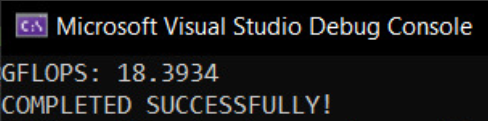

## C++

In [1]:
%%writefile softmax.cpp
#include <iostream>
#include <vector>
#include <cmath>
#include <chrono> // For timing

std::vector<float> softmax(const std::vector<float>& input) {
    std::vector<float> output(input.size());

    // Calculate sum of exponentials
    float sum_exp = 0.0f;
    for (float x : input) {
        sum_exp += std::exp(x);
    }

    // Calculate softmax for each element
    for (size_t i = 0; i < input.size(); ++i) {
        output[i] = std::exp(input[i]) / sum_exp;
    }

    return output;
}

int main() {
    const int num_elements = 10000000;  // Number of elements in the input vector

    // Generate a large input vector with random numbers
    std::vector<float> input(num_elements);
    for (int i = 0; i < num_elements; ++i) {
        input[i] = static_cast<float>(rand()) / RAND_MAX;  // Random number between 0 and 1
    }

    // Start timing
    auto start = std::chrono::high_resolution_clock::now();

    // Compute softmax
    std::vector<float> output = softmax(input);

    // End timing
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed_seconds = end - start;
    double elapsed_time = elapsed_seconds.count();

    // Print GFLOPS
    double gflops = (num_elements * 2) / (elapsed_time * 1e9);
    std::cout << "GFLOPS: " << gflops << std::endl;

    // Print the partial output
    std::cout << "Softmax output (partial):\n";
    for (int i = 0; i < 10; ++i) {
        std::cout << output[i] << " ";
    }
    std::cout << std::endl;

    return 0;
}



Writing softmax.cpp


In [2]:
!g++ softmax.cpp -o softmax_cpp

In [3]:
!./softmax_cpp

GFLOPS: 0.0175705
Softmax output (partial):
1.36532e-07 8.74226e-08 1.28956e-07 1.30949e-07 1.46645e-07 7.18027e-08 8.24006e-08 1.27052e-07 7.78003e-08 1.02549e-07 


## Numpy

In [4]:
import numpy as np
import time

def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtracting the maximum value for numerical stability
    return e_x / e_x.sum(axis=0)

# Generate a large input vector
num_elements = 10**7
input_vector = np.random.randn(num_elements)

# Start timing
start_time = time.time()

output_vector = softmax(input_vector)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

# Calculate GFLOPS
gflops = (num_elements * 2) / (elapsed_time * 1e9)
print("GFLOPS:", gflops)

# Print only a part of the output to avoid flooding the console
print("Softmax output (partial):")
print(output_vector[:10])  # Print only the first 10 elements


GFLOPS: 0.12765542229912238
Softmax output (partial):
[1.27364004e-07 4.23141400e-08 1.65752660e-08 1.82577864e-08
 2.74720117e-07 5.29335054e-08 1.12545045e-08 2.46906246e-08
 4.31180757e-08 4.97233609e-08]


## Performance Comparison

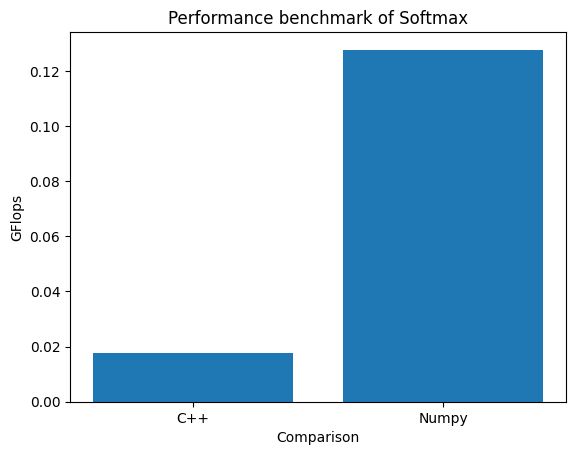

In [8]:
import matplotlib.pyplot as plt

# Sample data
categories = ['C++', 'Numpy']
values = [0.0175705, 0.12765542229912238]

# Plotting the bar graph
plt.bar(categories, values)

# Adding labels and title
plt.xlabel('Comparison')
plt.ylabel('GFlops')
plt.title('Performance benchmark of Softmax')

# Display the plot
plt.show()


# Convolution

## Cuda

In [7]:
%%cuda
// This program implements 2D convolution using Constant memory in CUDA

#include <cassert>
#include <cstdlib>
#include <iostream>
#include<chrono>
// 7 x 7 convolutional mask
#define MASK_DIM 7

// Amount the the matrix will hang over the matrix
#define MASK_OFFSET (MASK_DIM / 2)

// Allocate mask in constant memory
__constant__ int mask[7 * 7];

// 2D Convolution Kernel
// Takes:
//  matrix: Input matrix
//  result: Convolution result
//  N:      Dimensions of the matrices
__global__ void convolution_2d(int *matrix, int *result, int N) {
  // Calculate the global thread positions
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  // Starting index for calculation
  int start_r = row - MASK_OFFSET;
  int start_c = col - MASK_OFFSET;

  // Temp value for accumulating the result
  int temp = 0;

  // Iterate over all the rows
  for (int i = 0; i < MASK_DIM; i++) {
    // Go over each column
    for (int j = 0; j < MASK_DIM; j++) {
      // Range check for rows
      if ((start_r + i) >= 0 && (start_r + i) < N) {
        // Range check for columns
        if ((start_c + j) >= 0 && (start_c + j) < N) {
          // Accumulate result
          temp += matrix[(start_r + i) * N + (start_c + j)] *
                  mask[i * MASK_DIM + j];
        }
      }
    }
  }

  // Write back the result
  result[row * N + col] = temp;
}

// Initializes an n x n matrix with random numbers
// Takes:
//  m : Pointer to the matrix
//  n : Dimension of the matrix (square)
void init_matrix(int *m, int n) {
  for (int i = 0; i < n; i++) {
    for (int j = 0; j < n; j++) {
      m[n * i + j] = rand() % 100;
    }
  }
}

// Verifies the 2D convolution result on the CPU
// Takes:
//  m:      Original matrix
//  mask:   Convolutional mask
//  result: Result from the GPU
//  N:      Dimensions of the matrix
void verify_result(int *m, int *mask, int *result, int N) {
  // Temp value for accumulating results
  int temp;

  // Intermediate value for more readable code
  int offset_r;
  int offset_c;

  // Go over each row
  for (int i = 0; i < N; i++) {
    // Go over each column
    for (int j = 0; j < N; j++) {
      // Reset the temp variable
      temp = 0;

      // Go over each mask row
      for (int k = 0; k < MASK_DIM; k++) {
        // Update offset value for row
        offset_r = i - MASK_OFFSET + k;

        // Go over each mask column
        for (int l = 0; l < MASK_DIM; l++) {
          // Update offset value for column
          offset_c = j - MASK_OFFSET + l;

          // Range checks if we are hanging off the matrix
          if (offset_r >= 0 && offset_r < N) {
            if (offset_c >= 0 && offset_c < N) {
              // Accumulate partial results
              temp += m[offset_r * N + offset_c] * mask[k * MASK_DIM + l];
            }
          }
        }
      }
      // Fail if the results don't match
      assert(result[i * N + j] == temp);
    }
  }
}

int main() {
  // Dimensions of the matrix (2 ^ 10 x 2 ^ 10)
  int N = 1 << 10;

  // Size of the matrix (in bytes)
  size_t bytes_n = N * N * sizeof(int);

  // Allocate the matrix and initialize it
  int *matrix = new int[N * N];
  int *result = new int[N * N];
  init_matrix(matrix, N);

  // Size of the mask in bytes
  size_t bytes_m = MASK_DIM * MASK_DIM * sizeof(int);

  // Allocate the mask and initialize it
  int *h_mask = new int[MASK_DIM * MASK_DIM];
  init_matrix(h_mask, MASK_DIM);

  // Allocate device memory
  int *d_matrix;
  int *d_result;
  cudaMalloc(&d_matrix, bytes_n);
  cudaMalloc(&d_result, bytes_n);

  // Copy data to the device
  cudaMemcpy(d_matrix, matrix, bytes_n, cudaMemcpyHostToDevice);
  cudaMemcpyToSymbol(mask, h_mask, bytes_m);

  // Calculate grid dimensions
  int THREADS = 16;
  int BLOCKS = (N + THREADS - 1) / THREADS;

  // Dimension launch arguments
  dim3 block_dim(THREADS, THREADS);
  dim3 grid_dim(BLOCKS, BLOCKS);

  // Perform 2D Convolution
    auto start_time = std::chrono::high_resolution_clock::now(); // Start timing
    convolution_2d<<<grid_dim, block_dim>>>(d_matrix, d_result, N);
    cudaDeviceSynchronize(); // Wait for kernel to finish
    auto end_time = std::chrono::high_resolution_clock::now(); // End timing

    // Calculate execution time in seconds
    std::chrono::duration<double> elapsed_seconds = end_time - start_time;
    double execution_time = elapsed_seconds.count();

    // Count floating point operations (assuming 2 operations per element)
    long long total_flops = 2 * static_cast<long long>(N * N * MASK_DIM * MASK_DIM);

    // Calculate GFLOPS
    double gflops = total_flops / (execution_time * 1e9);

    // Output GFLOPS
    std::cout << "GFLOPS: " << gflops << std::endl;

  // Copy the result back to the CPU
  cudaMemcpy(result, d_result, bytes_n, cudaMemcpyDeviceToHost);

  // Functional test
  verify_result(matrix, h_mask, result, N);

  std::cout << "COMPLETED SUCCESSFULLY!";

  // Free the memory we allocated
  delete[] matrix;
  delete[] result;
  delete[] h_mask;

  cudaFree(d_matrix);
  cudaFree(d_result);

  return 0;
}


UsageError: Cell magic `%%cuda` not found.


## Tensorflow

In [6]:
import tensorflow as tf
import numpy as np
import time

# Define the 2D convolution function using TensorFlow
def convolution_2d(matrix, mask):
    # Apply 2D convolution using TensorFlow
    result = tf.nn.conv2d(matrix, mask, strides=[1, 1, 1, 1], padding='SAME')
    return result
MASK_DIM = 7
# Generate random input matrix and mask
N = 1 << 10
matrix = np.random.randint(0, 100, size=(N, N)).astype(np.float32)
mask = np.random.randint(0, 100, size=(MASK_DIM, MASK_DIM)).astype(np.float32)

# Reshape the input matrix and mask for TensorFlow
matrix = tf.constant(matrix.reshape(1, N, N, 1))
mask = tf.constant(mask.reshape(MASK_DIM, MASK_DIM, 1, 1))

# Start timing
start_time = time.time()

# Perform 2D convolution
result = convolution_2d(matrix, mask)

# End timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time

# Count floating point operations (assuming 2 operations per element)
total_flops = 2 * N * N * MASK_DIM * MASK_DIM

# Calculate GFLOPS
gflops = total_flops / (execution_time * 1e9)

# Output GFLOPS
print("GFLOPS:", gflops)

# Note: Verify the result if needed


GFLOPS: 0.10116108987249543


## Numpy

In [5]:
import numpy as np
import time

# Dimensions of the matrix (2 ^ 10 x 2 ^ 10)
N = 1 << 10

# Size of the matrix
bytes_n = N * N * np.dtype(np.int32).itemsize

# Allocate the matrix and initialize it
matrix = np.random.randint(0, 100, size=(N, N)).astype(np.int32)
result = np.zeros_like(matrix)

# Allocate the mask and initialize it
mask_dim = 7
mask = np.random.randint(0, 100, size=(mask_dim, mask_dim)).astype(np.int32)

# Start timing
start_time = time.time()

# Perform 2D Convolution
for row in range(N):
    for col in range(N):
        temp = 0
        for i in range(mask_dim):
            for j in range(mask_dim):
                start_r = row - mask_dim // 2 + i
                start_c = col - mask_dim // 2 + j
                if start_r >= 0 and start_r < N and start_c >= 0 and start_c < N:
                    temp += matrix[start_r, start_c] * mask[i, j]
        result[row, col] = temp

# End timing
end_time = time.time()

# Calculate execution time in seconds
execution_time = end_time - start_time

# Count floating point operations (assuming 2 operations per element)
total_flops = 2 * N * N * mask_dim * mask_dim

# Calculate GFLOPS
gflops = total_flops / (execution_time * 1e9)

# Output GFLOPS
print("GFLOPS:", gflops)

GFLOPS: 0.001770930425117057


## Performance Comparison

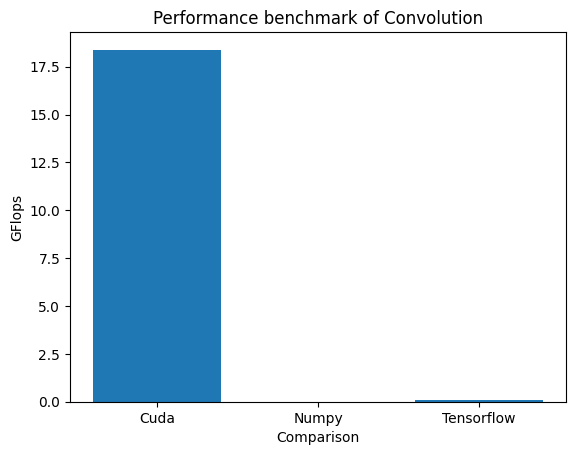

In [9]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Cuda', 'Numpy', 'Tensorflow']
values = [18.39, 0.001770930425117057, 0.10116108987249543]

# Plotting the bar graph
plt.bar(categories, values)

# Adding labels and title
plt.xlabel('Comparison')
plt.ylabel('GFlops')
plt.title('Performance benchmark of Convolution')

# Display the plot
plt.show()
